In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import pygmo as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

%matplotlib inline

from spineq.optimise import (
    calc_oa_weights,
    calc_coverage,
    optimise,
    get_optimisation_inputs,
)
from spineq.genetic import build_problem, run_problem, extract_all
from spineq.plotting import (
    plot_oa_importance,
    plot_oa_weights,
    plot_optimisation_result,
    plot_sensors,
    plot_coverage_grid,
    get_fig_grid,
    add_colorbar,
    add_scalebar,
    save_fig,
    networks_swarmplot,
)
from spineq.data_fetcher import get_uo_sensors, lad20nm_to_lad20cd
from spineq.urb_obs import get_uo_sensor_dict, plot_uo_coverage_grid
from spineq.utils import coverage_grid

In [2]:
lad20nm = "Gateshead"
lad20cd = lad20nm_to_lad20cd(lad20nm)

save_dir = Path("paper_figures", lad20cd)
os.makedirs(save_dir, exist_ok=True)
regen_results = True

population_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1, "title": "Total Population"},
    "pop_children": {"min": 0, "max": 16, "weight": 1, "title": "Children"},
    "pop_elderly": {"min": 70, "max": 90, "weight": 1, "title": "Elderly"},
}

all_groups = dict(population_groups)
all_groups["workplace"] = {"title": "Workplace"}

/Users/jroberts/opt/anaconda3/envs/spatial-inequality/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# fivethirtyeight style defaults but with white background
plt.style.use("fivethirtyeight")
mpl.rcParams["figure.facecolor"] = "white"

mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["axes.grid"] = False

mpl.rcParams["savefig.facecolor"] = "white"

## Distribution of Demographic Variables

In [4]:
oa_weights = {}

for name, weights in population_groups.items():
    oa_weights[name] = calc_oa_weights(
        lad20cd=lad20cd,
        pop_age_groups={name: weights},
        population_weight=1,
        workplace_weight=0,
    )

oa_weights["workplace"] = calc_oa_weights(
    lad20cd=lad20cd, population_weight=0, workplace_weight=1
)

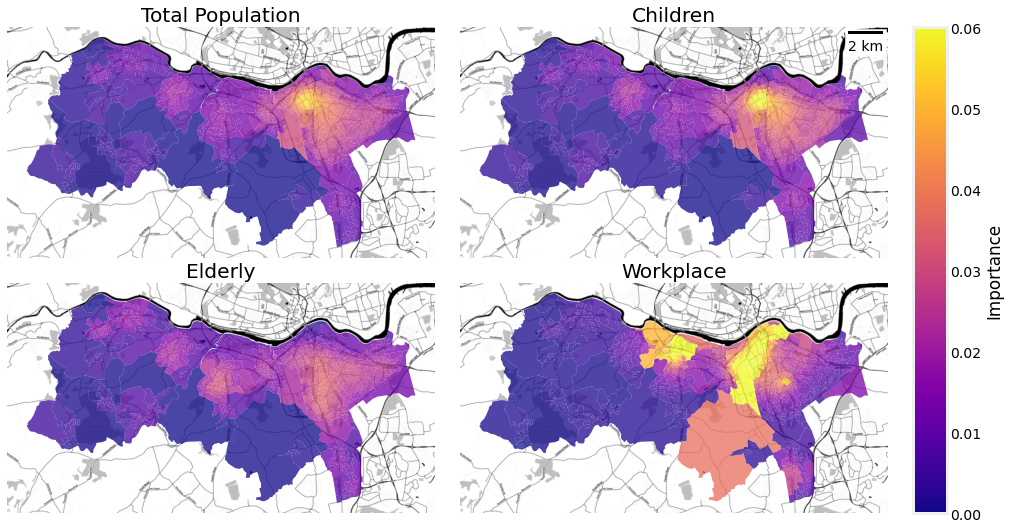

In [5]:
theta = 500
vmax = 0.06

fig, grid = get_fig_grid()

for i, g in enumerate(all_groups.items()):
    name = g[0]
    title = g[1]["title"]
    plot_oa_importance(
        lad20cd,
        oa_weights[name],
        theta=theta,
        vmax=vmax,
        ax=grid[i],
        show=False,
        legend=False,
        title=title,
    )
    if i == 1:
        add_scalebar(grid[i])

add_colorbar(grid[-1], vmax=vmax, label="Importance")
save_fig(fig, "demographics_importance.png", save_dir)

In [6]:
from spineq.data_fetcher import get_oa_shapes, get_oa_stats

oa = get_oa_shapes(lad20cd)
oa["area"] = oa["geometry"].area / 1e6  # km^2

stats = get_oa_stats(lad20cd)
for name, config in population_groups.items():
    group_pop = (
        stats["population_ages"]
        .loc[
            :,
            (stats["population_ages"].columns >= config["min"])
            & (stats["population_ages"].columns <= config["max"]),
        ]
        .sum(axis=1)
    )
    group_pop.name = name
    oa = oa.join(group_pop)

workplace = stats["workplace"]
workplace.name = "workplace"
oa = oa.join(workplace)

for group in all_groups.keys():
    oa[f"{group}_perc"] = oa[group] / oa[group].sum()
    oa[f"{group}_reld"] = oa[f"{group}_perc"] / oa["area"]

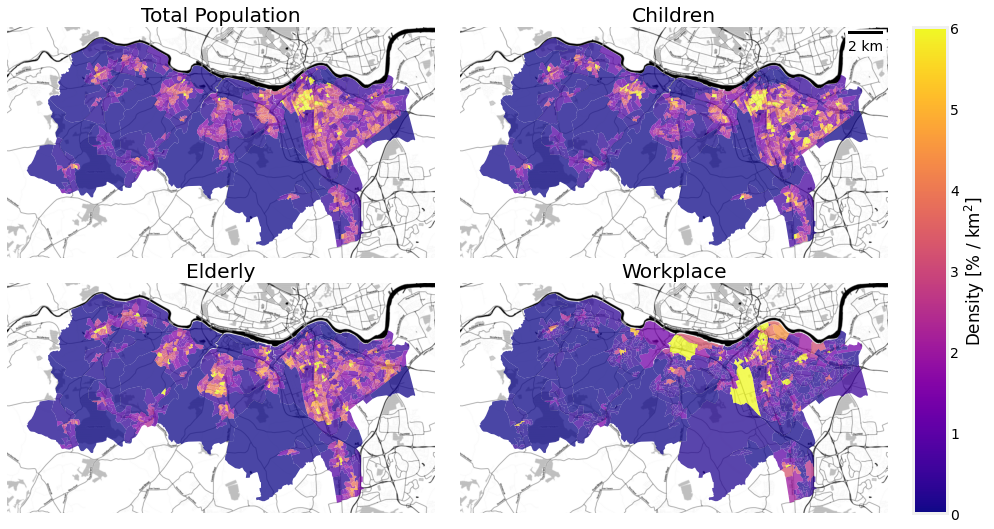

In [7]:
vmax = 6
fig, grid = get_fig_grid()

for i, g in enumerate(all_groups.items()):
    name = g[0]
    title = g[1]["title"]
    plot_oa_weights(
        lad20cd,
        100 * oa[f"{name}_reld"],
        title=title,
        vmax=vmax,
        ax=grid[i],
        legend=False,
        show=False,
    )
    if i == 1:
        add_scalebar(grid[i])

add_colorbar(grid[-1], vmax=vmax, label="Density [% / $\mathrm{km}^2$]")
save_fig(fig, "demographics_density.png", save_dir)

## Single-Variable Networks


In [8]:
thetas = [100, 250, 500]
n_sensors = [10, 20, 50, 55]

In [9]:
def create_single_obj_networks(thetas, n_sensors, results={}):
    for name, weights in population_groups.items():
        if name not in results.keys():
            results[name] = {}

        for theta in thetas:
            if f"theta{theta}" not in results[name].keys():
                results[name][f"theta{theta}"] = {}

            for n in n_sensors:
                print("=" * 20)
                print(name, ", theta", theta, ", n_sensors", n)
                print("=" * 20)
                result = optimise(
                    lad20cd=lad20cd,
                    n_sensors=n,
                    theta=theta,
                    population_weight=1,
                    workplace_weight=0,
                    pop_age_groups={name: weights},
                )
                results[name][f"theta{theta}"][f"{n}sensors"] = result

    name = "workplace"
    if name not in results.keys():
        results[name] = {}
    for theta in thetas:
        if f"theta{theta}" not in results[name].keys():
            results[name][f"theta{theta}"] = {}

        for n in n_sensors:
            print("=" * 20)
            print(name, ", theta", theta, ", n_sensors", n)
            print("=" * 20)
            result = optimise(
                lad20cd=lad20cd,
                n_sensors=n,
                theta=theta,
                population_weight=0,
                workplace_weight=1,
            )
            results[name][f"theta{theta}"][f"{n}sensors"] = result
    
    return results

In [ ]:
networks_path = Path(save_dir, "networks_singleobj.pkl")

if regen_results:
    results = create_single_obj_networks(thetas, n_sensors)

    with open(networks_path, "wb") as f:
        pickle.dump(results, f)

else:
    with open(networks_path, "rb") as f:
        results = pickle.load(f)

pop_total , theta 100 , n_sensors 10
Fetching data...
Placing sensor 1 out of 10 ... coverage = 0.01
Placing sensor 2 out of 10 ... coverage = 0.02
Placing sensor 3 out of 10 ... coverage = 0.02
Placing sensor 4 out of 10 ... coverage = 0.03
Placing sensor 5 out of 10 ... coverage = 0.03
Placing sensor 6 out of 10 ... coverage = 0.04
Placing sensor 7 out of 10 ... coverage = 0.04
Placing sensor 8 out of 10 ... coverage = 0.05
Placing sensor 9 out of 10 ... coverage = 0.05
Placing sensor 10 out of 10 ... coverage = 0.05
pop_total , theta 100 , n_sensors 20
Fetching data...
Placing sensor 1 out of 20 ... coverage = 0.01
Placing sensor 2 out of 20 ... coverage = 0.02
Placing sensor 3 out of 20 ... coverage = 0.02
Placing sensor 4 out of 20 ... coverage = 0.03
Placing sensor 5 out of 20 ... coverage = 0.03
Placing sensor 6 out of 20 ... coverage = 0.04
Placing sensor 7 out of 20 ... coverage = 0.04
Placing sensor 8 out of 20 ... coverage = 0.05
Placing sensor 9 out of 20 ... coverage = 0.0

Placing sensor 16 out of 20 ... coverage = 0.16
Placing sensor 17 out of 20 ... coverage = 0.17
Placing sensor 18 out of 20 ... coverage = 0.17
Placing sensor 19 out of 20 ... coverage = 0.18
Placing sensor 20 out of 20 ... coverage = 0.19
pop_total , theta 250 , n_sensors 50
Fetching data...
Placing sensor 1 out of 50 ... coverage = 0.02
Placing sensor 2 out of 50 ... coverage = 0.04
Placing sensor 3 out of 50 ... coverage = 0.05
Placing sensor 4 out of 50 ... coverage = 0.06
Placing sensor 5 out of 50 ... coverage = 0.07
Placing sensor 6 out of 50 ... coverage = 0.08
Placing sensor 7 out of 50 ... coverage = 0.08
Placing sensor 8 out of 50 ... coverage = 0.09
Placing sensor 9 out of 50 ... coverage = 0.10
Placing sensor 10 out of 50 ... coverage = 0.11
Placing sensor 11 out of 50 ... coverage = 0.12
Placing sensor 12 out of 50 ... coverage = 0.13
Placing sensor 13 out of 50 ... coverage = 0.13
Placing sensor 14 out of 50 ... coverage = 0.14
Placing sensor 15 out of 50 ... coverage = 

Placing sensor 22 out of 50 ... coverage = 0.37
Placing sensor 23 out of 50 ... coverage = 0.37
Placing sensor 24 out of 50 ... coverage = 0.38
Placing sensor 25 out of 50 ... coverage = 0.39
Placing sensor 26 out of 50 ... coverage = 0.39
Placing sensor 27 out of 50 ... coverage = 0.40
Placing sensor 28 out of 50 ... coverage = 0.41
Placing sensor 29 out of 50 ... coverage = 0.42
Placing sensor 30 out of 50 ... coverage = 0.42
Placing sensor 31 out of 50 ... coverage = 0.43
Placing sensor 32 out of 50 ... coverage = 0.43
Placing sensor 33 out of 50 ... coverage = 0.44
Placing sensor 34 out of 50 ... coverage = 0.45
Placing sensor 35 out of 50 ... coverage = 0.45
Placing sensor 36 out of 50 ... coverage = 0.46
Placing sensor 37 out of 50 ... coverage = 0.46
Placing sensor 38 out of 50 ... coverage = 0.47
Placing sensor 39 out of 50 ... coverage = 0.47
Placing sensor 40 out of 50 ... coverage = 0.48
Placing sensor 41 out of 50 ... coverage = 0.48
Placing sensor 42 out of 50 ... coverage

Placing sensor 50 out of 50 ... coverage = 0.21
pop_children , theta 100 , n_sensors 55
Fetching data...
Placing sensor 1 out of 55 ... coverage = 0.01
Placing sensor 2 out of 55 ... coverage = 0.02
Placing sensor 3 out of 55 ... coverage = 0.03
Placing sensor 4 out of 55 ... coverage = 0.04
Placing sensor 5 out of 55 ... coverage = 0.04
Placing sensor 6 out of 55 ... coverage = 0.05
Placing sensor 7 out of 55 ... coverage = 0.05
Placing sensor 8 out of 55 ... coverage = 0.06
Placing sensor 9 out of 55 ... coverage = 0.06
Placing sensor 10 out of 55 ... coverage = 0.07
Placing sensor 11 out of 55 ... coverage = 0.07
Placing sensor 12 out of 55 ... coverage = 0.08
Placing sensor 13 out of 55 ... coverage = 0.08
Placing sensor 14 out of 55 ... coverage = 0.09
Placing sensor 15 out of 55 ... coverage = 0.09
Placing sensor 16 out of 55 ... coverage = 0.09
Placing sensor 17 out of 55 ... coverage = 0.10
Placing sensor 18 out of 55 ... coverage = 0.10
Placing sensor 19 out of 55 ... coverage

Placing sensor 26 out of 55 ... coverage = 0.25
Placing sensor 27 out of 55 ... coverage = 0.26
Placing sensor 28 out of 55 ... coverage = 0.26
Placing sensor 29 out of 55 ... coverage = 0.27
Placing sensor 30 out of 55 ... coverage = 0.28
Placing sensor 31 out of 55 ... coverage = 0.28
Placing sensor 32 out of 55 ... coverage = 0.29
Placing sensor 33 out of 55 ... coverage = 0.29
Placing sensor 34 out of 55 ... coverage = 0.30
Placing sensor 35 out of 55 ... coverage = 0.30
Placing sensor 36 out of 55 ... coverage = 0.31
Placing sensor 37 out of 55 ... coverage = 0.31
Placing sensor 38 out of 55 ... coverage = 0.32
Placing sensor 39 out of 55 ... coverage = 0.32
Placing sensor 40 out of 55 ... coverage = 0.32
Placing sensor 41 out of 55 ... coverage = 0.33
Placing sensor 42 out of 55 ... coverage = 0.33
Placing sensor 43 out of 55 ... coverage = 0.34
Placing sensor 44 out of 55 ... coverage = 0.34
Placing sensor 45 out of 55 ... coverage = 0.35
Placing sensor 46 out of 55 ... coverage

Placing sensor 54 out of 55 ... coverage = 0.57
Placing sensor 55 out of 55 ... coverage = 0.57
pop_elderly , theta 100 , n_sensors 10
Fetching data...
Placing sensor 1 out of 10 ... coverage = 0.01
Placing sensor 2 out of 10 ... coverage = 0.01
Placing sensor 3 out of 10 ... coverage = 0.02
Placing sensor 4 out of 10 ... coverage = 0.02
Placing sensor 5 out of 10 ... coverage = 0.03
Placing sensor 6 out of 10 ... coverage = 0.03
Placing sensor 7 out of 10 ... coverage = 0.04
Placing sensor 8 out of 10 ... coverage = 0.04
Placing sensor 9 out of 10 ... coverage = 0.05
Placing sensor 10 out of 10 ... coverage = 0.05
pop_elderly , theta 100 , n_sensors 20
Fetching data...
Placing sensor 1 out of 20 ... coverage = 0.01
Placing sensor 2 out of 20 ... coverage = 0.01
Placing sensor 3 out of 20 ... coverage = 0.02
Placing sensor 4 out of 20 ... coverage = 0.02
Placing sensor 5 out of 20 ... coverage = 0.03
Placing sensor 6 out of 20 ... coverage = 0.03
Placing sensor 7 out of 20 ... coverage

Placing sensor 13 out of 20 ... coverage = 0.14
Placing sensor 14 out of 20 ... coverage = 0.15
Placing sensor 15 out of 20 ... coverage = 0.16
Placing sensor 16 out of 20 ... coverage = 0.17
Placing sensor 17 out of 20 ... coverage = 0.17
Placing sensor 18 out of 20 ... coverage = 0.18
Placing sensor 19 out of 20 ... coverage = 0.19
Placing sensor 20 out of 20 ... coverage = 0.19
pop_elderly , theta 250 , n_sensors 50
Fetching data...
Placing sensor 1 out of 50 ... coverage = 0.01
Placing sensor 2 out of 50 ... coverage = 0.03
Placing sensor 3 out of 50 ... coverage = 0.04
Placing sensor 4 out of 50 ... coverage = 0.05
Placing sensor 5 out of 50 ... coverage = 0.06
Placing sensor 6 out of 50 ... coverage = 0.07
Placing sensor 7 out of 50 ... coverage = 0.08
Placing sensor 8 out of 50 ... coverage = 0.10
Placing sensor 9 out of 50 ... coverage = 0.10
Placing sensor 10 out of 50 ... coverage = 0.11
Placing sensor 11 out of 50 ... coverage = 0.12
Placing sensor 12 out of 50 ... coverage 

In [ ]:
thetas_to_plot = [100, 500]
sensors_to_plot = [10, 55]

for plot_obj in all_groups.keys():
    fig, grid = get_fig_grid()
    i = 0
    for t in thetas_to_plot:
        for s in sensors_to_plot:
            r = results[plot_obj][f"theta{t}"][f"{s}sensors"]
            plot_optimisation_result(
                r,
                title=f"n = {s}, $\\theta$ = {t} m, c = {r['total_coverage']:.2f}",
                ax=grid[i],
                show=False,
                legend=False,
                sensor_size=50,
                sensor_color="green",
                sensor_edgecolor="yellow",
                sensor_linewidth=1.5,
            )
            if i == 1:
                add_scalebar(grid[i])

            i += 1

    add_colorbar(grid[-1], label="Coverage", cmap="Greens")

    fig.suptitle(all_groups[plot_obj]["title"], y=0.87, fontsize=20)
    t_str = "theta" + "_".join(str(t) for t in thetas_to_plot)
    n_str = "nsensors" + "_".join(str(n) for n in sensors_to_plot)
    save_fig(fig, f"{plot_obj}_{t_str}_{n_str}.png", save_dir)

### Coverage vs. No. Sensors

In [ ]:
theta = 500
fig, ax = plt.subplots(1, 1)
for obj in all_groups.keys():
    cov_history = results[obj][f"theta{theta}"][f"55sensors"]["coverage_history"]
    ax.plot(range(1, len(cov_history) + 1), cov_history, label=all_groups[obj]["title"])

ax.set_xlabel("No. Sensors")
ax.set_ylabel("Coverage")
ax.legend()
save_fig(fig, "coverage_vs_nsensors.png", save_dir)

## Comparison with existing network of air quality sensors


### Sensors at original locations (gridded coverage)

In [ ]:
theta = 500

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
uo_sensors = get_uo_sensors(lad20cd)
plot_sensors(lad20cd, uo_sensors, centroids=False, ax=ax)
add_scalebar(ax)
t_str = f"theta_{theta}"
n_str = f"nsensors_{len(uo_sensors)}"
save_fig(fig, f"urb_obs_sensors_{t_str}_{n_str}.png", save_dir)

In [ ]:
fig, ax = get_fig_grid(nrows_ncols=(1, 1))
ax = ax[0]
cmap = "Greens"
plot_uo_coverage_grid(lad20cd, ax=ax, legend=False, cmap=cmap)
add_colorbar(ax, cmap=cmap, label="Coverage")
add_scalebar(ax)
t_str = f"theta_{theta}"
n_str = f"nsensors_{len(uo_sensors)}"
save_fig(fig, f"urb_obs_coverage_grid_{t_str}_{n_str}.png", save_dir)

In [ ]:
uo_sensors_xy = np.array(
    [uo_sensors["geometry"].x.values, uo_sensors["geometry"].y.values]
).T

oa = get_oa_shapes(lad20cd)
bounds = oa["geometry"].bounds
xlim = (bounds["minx"].min(), bounds["maxx"].max())
ylim = (bounds["miny"].min(), bounds["maxy"].max())

grid_size = 100
uo_cov = coverage_grid(uo_sensors_xy, xlim, ylim, theta=theta, grid_size=grid_size)

In [ ]:
n_uo_sensors = len(uo_sensors)
n_uo_oa = uo_sensors["oa11cd"].nunique()

if n_uo_oa not in n_sensors:
    results = create_single_obj_networks([theta], [n_uo_oa], results=results)

    with open(networks_path, "wb") as f:
        pickle.dump(results, f)

In [ ]:
fig, grid = get_fig_grid()
cmap = "seismic"
vmin = -1
vmax = 1
i = 0
for name, config in all_groups.items():
    greedy_sensors = pd.DataFrame(results[name][f"theta{theta}"][f"{n_uo_oa}sensors"]["sensors"])
    greedy_sensors = np.array(greedy_sensors[["x", "y"]])
    greedy_cov = coverage_grid(
        greedy_sensors, xlim, ylim, theta=theta, grid_size=grid_size
    )
    cov_diff = uo_cov.copy()
    cov_diff["coverage"] = greedy_cov["coverage"] - uo_cov["coverage"]

    plot_coverage_grid(
        lad20cd,
        cov_diff,
        ax=grid[i],
        vmin=vmin,
        vmax=vmax,
        legend=False,
        cmap=cmap,
        title=config["title"],
    )
    i += 1

add_scalebar(grid[1])
add_colorbar(grid[-1], cmap=cmap, vmin=vmin, vmax=vmax, label="Coverage Difference")

fig.suptitle(
    f"Comparisons with Urban Observatory Network (n = {n_uo_oa}, $\\theta$ = {theta} m)",
    y=0.87,
    fontsize=20,
)
t_str = f"theta_{theta}"
n_str = f"nsensors_{n_uo_oa}"
save_fig(fig, f"urb_obs_coverage_difference_grid_{t_str}_{n_str}.png", save_dir)

### Sensors snapped to OA centroids

In [ ]:
uo_sensor_dict = get_uo_sensor_dict(lad20cd)

uo_coverage = {}
title = f"Urban Observatory: Coverage with $\\theta$ = {theta} m\n"
for name, config in all_groups.items():
    uo_coverage[name] = calc_coverage(
        lad20cd, uo_sensor_dict, oa_weight=oa_weights[name], theta=theta
    )
    uo_coverage[name]["sensors"] = uo_sensor_dict
    uo_coverage[name]["lad20cd"] = lad20cd
    title += f"{config['title']}: {uo_coverage[name]['total_coverage']:.2f}, "
title = title[:-2]

fig, ax = get_fig_grid(nrows_ncols=(1, 1))
plot_optimisation_result(
    uo_coverage[name],
    title=title,
    ax=ax[0],
    show=False,
    legend=False,
    sensor_size=50,
    sensor_color="green",
    sensor_edgecolor="yellow",
    sensor_linewidth=1.5,
)
add_scalebar(ax[0])
add_colorbar(ax[0], cmap="Greens", label="Coverage")

t_str = f"theta_{theta}"
n_str = f"nsensors_{len(uo_sensor_dict)}"
save_fig(fig, f"urb_obs_coverage_oa_{t_str}_{n_str}.png", save_dir)

In [ ]:
import contextily as ctx

fig, grid = get_fig_grid()
i = 0
for name, config in all_groups.items():
    uo_cov = uo_coverage[name]["oa_coverage"]
    uo_cov = pd.DataFrame(uo_cov).set_index("oa11cd")
    uo_cov.rename(columns={"coverage": "urb_obs"}, inplace=True)

    greedy_cov = results[name][f"theta{theta}"][f"{n_uo_oa}sensors"]["oa_coverage"]
    greedy_cov = pd.DataFrame(greedy_cov).set_index("oa11cd")
    greedy_cov.rename(columns={"coverage": "greedy"}, inplace=True)

    compare_nets = uo_cov.join(greedy_cov)
    compare_nets["diff"] = compare_nets["greedy"] - compare_nets["urb_obs"]
    compare_nets["diff"].describe()

    oa_shapes = get_oa_shapes(lad20cd)
    oa_shapes = oa_shapes.join(compare_nets["diff"])

    cmap = "bwr"
    vmin = -1
    vmax = 1
    oa_shapes.plot(
        column="diff", alpha=0.75, cmap=cmap, ax=grid[i], vmin=vmin, vmax=vmax
    )

    ctx.add_basemap(
        grid[i],
        source="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
        crs=oa_shapes.crs.to_epsg(),
    )

    grid[i].set_axis_off()
    grid[i].set_title(config["title"])
    i += 1

add_scalebar(grid[1])
add_colorbar(grid[-1], cmap=cmap, label="Coverage Difference", vmin=vmin, vmax=vmax)
fig.suptitle(
    f"Comparisons with Urban Observatory Network (n = {n_uo_oa}, $\\theta$ = {theta} m)",
    y=0.87,
    fontsize=20,
)

t_str = f"theta_{theta}"
n_str = f"nsensors_{len(uo_sensor_dict)}"
save_fig(fig, f"urb_obs_coverage_difference_oa_{t_str}_{n_str}.png", save_dir)

In [ ]:
cov = pd.DataFrame(results["pop_children"][f"theta{theta}"][f"{n_uo_oa}sensors"]["oa_coverage"])
w = oa_weights["pop_children"]
w.name = "weight"
cov = cov.join(w, on="oa11cd")
np.average(cov["coverage"], weights=cov["weight"])

## Multi-Objective Optimisation (Genetic Algorithm)

### 4 Objectives

In [ ]:
seed = 123
pg.set_global_rng_seed(seed=seed)

In [ ]:
n_sensors = [10, 55]
if n_uo_oa not in n_sensors:
    n_sensors.append(n_uo_oa)

thetas = [100, 500]
gen = 1000
population_size = 200
networks_path = Path(save_dir, "networks_multiobj.pkl")

inputs = get_optimisation_inputs(
    lad20cd=lad20cd,
    population_weight=1,
    workplace_weight=1,
    pop_age_groups=population_groups,
    combine=False,
)

if regen_results:
    results = {}
    for t in thetas:
        results[f"theta{t}"] = {}
        for ns in n_sensors:
            print("theta", t, ", n_sensors", ns)
            prob = build_problem(inputs, n_sensors=ns, theta=t)
            pop = run_problem(prob, uda=pg.nsga2(gen=gen), population_size=population_size, verbosity=1)
            results[f"theta{t}"][f"{ns}sensors"] = pop
            with open(networks_path, "wb") as f:
                pickle.dump(results, f)

else:
    with open(networks_path, "rb") as f:
        results = pickle.load(f)

In [ ]:
theta = 500
r = results[f"theta{theta}"]["55sensors"]
scores, solutions = extract_all(r)
scores = -scores

print("Best fitness values for single objectives:")
objs = list(inputs["oa_weight"].keys())
for i in range(len(inputs["oa_weight"])):
    print(objs[i], scores[:, i].max())

#### All objectives > 0.45

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
threshold = 0.45
objs = [g["title"] for g in all_groups.values()]
networks_swarmplot(scores, objs, thresholds=threshold, ax=ax)
save_fig(
    fig, f"multiobj_theta{theta}_55sensors_above{round(threshold * 100)}cov.png", save_dir
)

#### Workplace > 0.65

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
threshold = {"Workplace": 0.65}
networks_swarmplot(scores, objs, thresholds=threshold, ax=ax)
save_fig(
    fig,
    f"multiobj_theta{theta}_55sensors_workabove{round(threshold['Workplace'] * 100)}cov.png",
    save_dir,
)

#### Max coverage of children with workplace coverage > 0.65

In [ ]:
work_threshold = 0.65
work_idx = 3
idx = scores[scores[:, work_idx] > work_threshold, 1].argmax()
sensor_idx = solutions[scores[:, 3] > work_threshold][idx].astype(int)
cov = scores[scores[:, work_idx] > work_threshold][idx]

sensor_dict = [
    {
        "oa11cd": inputs["oa11cd"][idx],
        "x": inputs["oa_x"][idx],
        "y": inputs["oa_y"][idx],
    }
    for idx in sensor_idx
]

coverage = calc_coverage(lad20cd, sensor_dict, oa_weight=oa_weights[name], theta=theta)
coverage["sensors"] = sensor_dict
coverage["lad20cd"] = lad20cd

title = ""
for obj, score in zip(objs, cov):
    title += f"{obj} = {score:.2f}, "

title = title[:-2]
title += f"\n(n = 55, $\\theta$ = {theta} m)"

fig, ax = get_fig_grid(nrows_ncols=(1, 1))
plot_optimisation_result(
    coverage,
    title=title,
    ax=ax[0],
    show=False,
    legend=False,
    sensor_size=50,
    sensor_color="green",
    sensor_edgecolor="yellow",
    sensor_linewidth=1.5,
)
add_scalebar(ax[0])
add_colorbar(ax[0], cmap="Greens", label="Coverage")
save_fig(
    fig,
    f"multiobj_wplace{round(cov[3], 2)}_child{round(cov[1], 2)}_theta{theta}_55sensors.png",
    save_dir,
)

#### Coverage > Urban Observatory

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
threshold = {
    "Workplace": uo_coverage["workplace"]["total_coverage"],
    "Total Population": uo_coverage["pop_total"]["total_coverage"],
    "Children": uo_coverage["pop_children"]["total_coverage"],
    "Elderly": uo_coverage["pop_elderly"]["total_coverage"],
}

r = results[f"theta{theta}"][f"{n_uo_oa}sensors"]
scores, solutions = extract_all(r)
scores = -scores

ax = networks_swarmplot(scores, objs, thresholds=threshold, ax=ax)
ax.set_ylim([0, 1])
save_fig(fig, f"multiobj_theta{theta}_{n_uo_oa}sensors_above_urbobs.png", save_dir)

#### Highlight One

In [ ]:
save_single_dir = Path(save_dir, "multiobj_highlightsingle")
os.makedirs(save_single_dir, exist_ok=True)

for idx in range(len(scores)):
    print(idx)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax = networks_swarmplot(scores, objs, thresholds=idx, ax=ax)
    title = f"Network {idx + 1}\n"
    cov = scores[idx]
    for obj, score in zip(objs, cov):
        title += f"{obj} = {score:.2f}, "
    ax.set_title(title[:-2], fontsize=16)
    ax.set_ylim(0, 1)
    save_fig(
        fig,
        f"multiobj_theta{theta}_55sensors_select_{idx + 1:02d}.png",
        save_single_dir,
        dpi=200,
    )
    plt.close()

#### Maximise minimum coverage across all objectives

In [ ]:
# find network that has the maximum minimum coverage across all objectives
# (i.e. find network where all objectives have a coverage of at least t, for
# highest possible t)
t = scores.min()
delta = 0.001
remaining = len(scores)
while remaining > 0:
    t += delta
    remaining = (scores > t).all(axis=1).sum()
t -= delta

best_idx = (scores > t).all(axis=1).argmax()
print(t, scores[best_idx])

In [ ]:
sensor_idx = solutions[best_idx].astype(int)
sensor_dict = [
    {
        "oa11cd": inputs["oa11cd"][idx],
        "x": inputs["oa_x"][idx],
        "y": inputs["oa_y"][idx],
    }
    for idx in sensor_idx
]

coverage = calc_coverage(
    lad20cd, sensor_dict, oa_weight=oa_weights["pop_total"], theta=theta
)
coverage["sensors"] = sensor_dict
coverage["lad20cd"] = lad20cd

title = ""
for obj, score in zip(objs, scores[best_idx]):
    title += f"{obj} = {score:.2f}, "

title = title[:-2]
title += f"\n(n = 55, $\\theta$ = {theta} m)"

fig, ax = get_fig_grid(nrows_ncols=(1, 1))
plot_optimisation_result(
    coverage,
    title=title,
    ax=ax[0],
    show=False,
    legend=False,
    sensor_size=50,
    sensor_color="green",
    sensor_edgecolor="yellow",
    sensor_linewidth=1.5,
)
add_scalebar(ax[0])
add_colorbar(ax[0], cmap="Greens", label="Coverage")
save_fig(fig, f"multiobj_compromise_theta{theta}_55sensors_cov{round(t, 3)}.png", save_dir)

### 2 Objectives: Elderly & Workplace

In [ ]:
n_sensors = [10, 55]
thetas = [500]
gen = 1000
population_size = 200
networks_path = Path(save_dir, "networks_2obj.pkl")

inputs = get_optimisation_inputs(
    lad20cd=lad20cd,
    population_weight=1,
    workplace_weight=1,
    pop_age_groups={"pop_elderly": population_groups["pop_elderly"]},
    combine=False,
)

if regen_results:
    results = {}
    for t in thetas:
        results[f"theta{t}"] = {}
        for ns in n_sensors:
            print("theta", t, ", n_sensors", ns)
            prob = build_problem(inputs, n_sensors=ns, theta=t)
            pop = run_problem(
                prob,
                uda=pg.nsga2(gen=gen),
                population_size=population_size,
                verbosity=1,
            )
            results[f"theta{t}"][f"{ns}sensors"] = pop
            with open(networks_path, "wb") as f:
                pickle.dump(results, f)

else:
    with open(networks_path, "rb") as f:
        results = pickle.load(f)

In [ ]:
r = results["theta500"]["55sensors"]
scores, solutions = extract_all(r)
scores = -scores

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(scores[:,1], scores[:,0], 'o')
ax.set_ylabel(all_groups["pop_elderly"]["title"], fontsize=14)
ax.set_xlabel(all_groups["workplace"]["title"], fontsize=14)
ax.axis("equal")

save_fig(fig, f"2obj_theta100_55sensors.png", save_dir)

In [ ]:
rank_work_idx = scores[:, 1].argsort()
ranks_to_plot = np.linspace(0, population_size - 1, 4).astype(int)

fig, ax = get_fig_grid()
for i, rank in enumerate(ranks_to_plot):
    idx = rank_work_idx[rank]
    sensor_idx = solutions[idx].astype(int)
    sensor_dict = [
        {
            "oa11cd": inputs["oa11cd"][idx],
            "x": inputs["oa_x"][idx],
            "y": inputs["oa_y"][idx],
        }
        for idx in sensor_idx
    ]
    coverage = calc_coverage(
        lad20cd, sensor_dict, oa_weight=oa_weights["pop_total"], theta=theta
    )
    coverage["sensors"] = sensor_dict
    coverage["lad20cd"] = lad20cd

    title = ""
    for obj, score in zip(["pop_elderly", "workplace"], scores[idx]):
        title += f"{all_groups[obj]['title']} = {score:.2f}, "

    title = title[:-2]

    plot_optimisation_result(
        coverage,
        title=title,
        ax=ax[i],
        show=False,
        legend=False,
        sensor_size=50,
        sensor_color="green",
        sensor_edgecolor="yellow",
        sensor_linewidth=1.5,
    )

add_scalebar(ax[1])
add_colorbar(ax[-1], cmap="Greens", label="Coverage")
fig.suptitle(f"n = 55, $\\theta$ = 500 m", y=0.87, fontsize=20)
save_fig(fig, f"2obj_spectrum_theta500_55sensors.png", save_dir)